In [95]:
import mlrun
# get/create a project and register the data prep and trainer function in it
project = mlrun.get_or_create_project(
    name="ny-taxi-monitor-demo-3", user_project=True, context="./"
)

> 2022-11-17 16:07:29,058 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 16:07:29,059 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 16:07:29,092 [info] Username was normalized to match the required pattern for project name: {'username': 'Davesh', 'normalized_username': 'davesh'}
> 2022-11-17 16:07:44,675 [info] loaded project ny-taxi-monitor-demo-3 from None or context and saved in MLRun DB


In [96]:
project.set_function('src/data_prep.py', 'data-prep', image='mlrun/ml-models',
                     handler='data_preparation', kind="job")
project.set_function('src/trainer.py', 'trainer', image='mlrun/ml-models',
                     handler='train', kind="job")
project.set_function("src/serving.py", name='serving', image='mlrun/ml-models',
                     kind="serving")
project.save()

In [97]:
# Register the workflow file:
workflow_name = "lgbm_ny_taxi_pipeline"
project.set_workflow(workflow_name, "src/workflow.py")

# Save the project:
project.save()

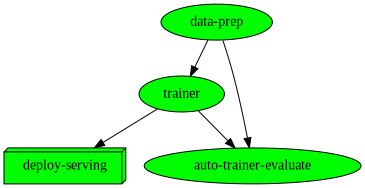

> 2022-11-17 16:23:38,072 [warning] No slack webhook is set, skipping notification
[info] Workflow 03d95dd3-6bf3-431e-bf9d-72942ffefcfb finished, state=Succeeded
status     name                   uid       results
---------  ---------------------  --------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
completed  auto-trainer-evaluate  ..aacd3f  evaluation_mean_absolute_error=1.7510033166414447,evaluation_r2_score=0.7937170970746888,evaluation_root_mean_squared_error=4.5742077268541,evaluation_mean_squared_error=20.923376328411756
completed  trainer                ..38ddd7  best_iteration=1,mean_absolute_error=1.7478981603415498,r2_score=0.7899553210994961,root_mean_squared_error=4.462965125033805,mean_squared_error=19.91805770726801
completed  data-prep              ..c1fea6  label_column=fare_amount


uid,start,state,name,parameters,results
...8caacd3f,Nov 17 16:19:50,completed,auto-trainer-evaluate,model=store://artifacts/ny-taxi-monitor-demo-3-davesh/lgbm_ny_taxi:03d95dd3-6bf3-431e-bf9d-72942ffefcfblabel_columns=fare_amount,evaluation_mean_absolute_error=1.7510033166414447evaluation_r2_score=0.7937170970746888evaluation_root_mean_squared_error=4.5742077268541evaluation_mean_squared_error=20.923376328411756
...7d38ddd7,Nov 17 16:08:20,completed,trainer,,best_iteration=1mean_absolute_error=1.7478981603415498r2_score=0.7899553210994961root_mean_squared_error=4.462965125033805mean_squared_error=19.91805770726801
...fec1fea6,Nov 17 16:07:56,completed,data-prep,,label_column=fare_amount


In [98]:
workflow_run = project.run(
    name=workflow_name,
    arguments={
        "dataset": "https://s3.us-east-1.wasabisys.com/iguazio/data/nyc-taxi/train.csv",
    },
    watch=True,
)

In [99]:
serving_function = project.get_function("serving")

In [100]:
response = serving_function.invoke(path='/predict', body= {'pickup_longitude':-1.291193, 'pickup_latitude':0.711038, 'dropoff_longitude':-1.291353, 'dropoff_latitude': 0.710814, 
                                               'passenger_count':1, 'jfk_dist':40.446493, 'ewr_dist':32.342093, 'lga_dist':21.273835, 'sol_dist':14.063759, 'nyc_dist':5.607925, 
                                               'timestamp': '2013-01-01T12'})
print(response)

> 2022-11-17 16:23:38,246 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-monitor-demo-3-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 7.093600037657522'


# Simulate incoming data

In [101]:
from src.data_prep import *
import numpy as np
# Load the dataset
data = mlrun.get_dataitem("data/dataset.csv").as_df()

data = radian_conv_step(add_airport_dist(clean_df(data).dropna(how="any", axis="rows"))).drop(columns=["key", 'fare_amount']).rename(columns={'pickup_datetime': 'timestamp'})

In [104]:
from random import choice, uniform
from time import sleep
from tqdm.notebook import trange, tqdm

# Sending random requests
for i in trange(150):
    data_point = data.iloc[i].to_dict()
    try:
        resp = serving_function.invoke(path='/predict', body=data_point)
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

  0%|          | 0/100 [00:00<?, ?it/s]

> 2022-11-17 16:29:39,229 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-monitor-demo-3-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 12.210913270648062'
> 2022-11-17 16:29:39,581 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-monitor-demo-3-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 17.387986332428934'
> 2022-11-17 16:29:41,000 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-monitor-demo-3-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 5.0930747215522745'
> 2022-11-17 16:29:42,396 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-ny-taxi-monitor-demo-3-davesh-serving.default-tenant.svc.cluster.local:8080/predict'}
b'predicted fare amount is 8.96496092720955'
> 2022-11-17 16:29:43,535 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-